In [1]:
import tqdm
import pickle
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

import xgboost as xgb
from zeo_amd.classify import get_metrics, get_datasets

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

feat = pd.read_csv("../data/zeo-features.csv", index_col=0)

In [3]:
TEST_SIZE = 0.3
RANDOM_SEED = 42

## Training a balanced classifier

In [5]:
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
)

results = []
_LABELS = synth.columns
THRESHOLD = 0.25
MINIMUM_POSITIVE = 10

for _label in tqdm.tqdm_notebook(_LABELS):
    # Get the information for the dataset
    X = dm
    y = (synth[_label] > THRESHOLD)
    
    n_pos = y.sum()

    if n_pos <= MINIMUM_POSITIVE:
        continue
    
    X_train, X_test, y_train, y_test = get_datasets(X, y, balanced=True)

    # Fitting the classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    results.append({
        "label": _label,
        "classifier": type(clf).__name__,
        "y_test": y_test,
        "y_pred": y_pred,
        "n_pos": y_train.sum(),
        "n_neg": (1 - y_train).sum(),
        **get_metrics(y_test, y_pred, y_score),
    })

results_df = pd.DataFrame(results)

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_43756/410135447.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _label in tqdm.tqdm_notebook(_LABELS):


  0%|          | 0/38 [00:00<?, ?it/s]

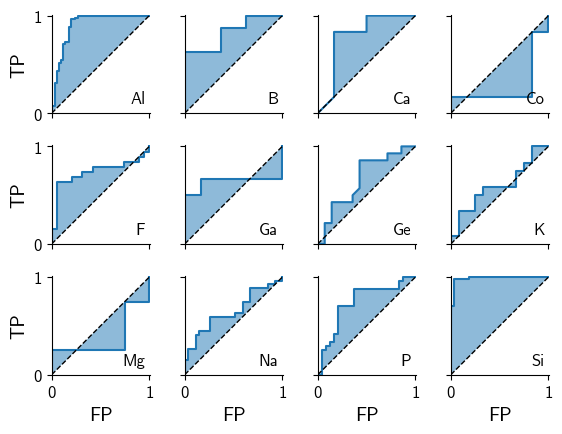

In [6]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["fpr"].item()
    _y = _df["tpr"].item()
    random = np.linspace(0, 1, len(_x))
    
    ax.plot(_x, _y)
    ax.plot(_x, _x, linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        _x,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
#     ax.set_xlabel("FP")
#     ax.set_ylabel("TP")
    ax.annotate(label, (0.95, 0.1), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("FP")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("TP")
    
    
fig.tight_layout()

plt.show()

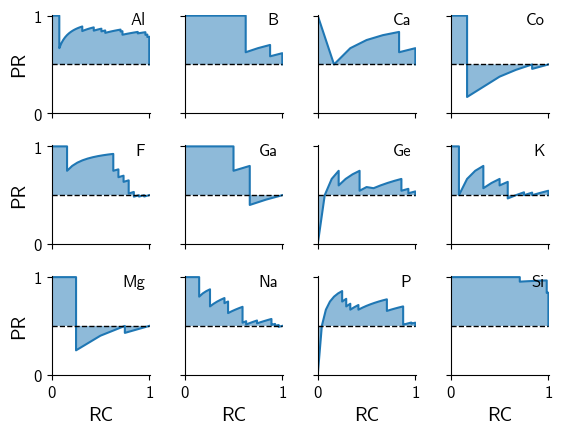

In [7]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["rc"].item()
    _y = _df["pr"].item()
    
    baseline = _df["n_pos"] / (_df["n_pos"] + _df["n_neg"])
    
    ax.plot(_x, _y)
    ax.plot([0, 1], [baseline, baseline], linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        baseline,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
    ax.annotate(label, (0.95, 0.9), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("RC")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("PR")
    
    
fig.tight_layout()

plt.show()

In [8]:
results_df[["label", "accuracy", "precision", "recall", "F1-score", "roc_auc"]]

,label,accuracy,precision,recall,F1-score,roc_auc
0,Al,0.784314,0.822222,0.725490,0.770833,0.899654
1,B,0.687500,0.666667,0.750000,0.705882,0.828125
2,Ca,0.750000,0.714286,0.833333,0.769231,0.791667
3,Co,0.166667,0.166667,0.166667,0.166667,0.277778
4,F,0.684211,0.684211,0.684211,0.684211,0.736842
5,Ga,0.416667,0.444444,0.666667,0.533333,0.638889
6,Ge,0.571429,0.571429,0.571429,0.571429,0.665816
7,K,0.541667,0.529412,0.750000,0.620690,0.597222
8,Mg,0.250000,0.250000,0.250000,0.250000,0.375000
9,Na,0.537037,0.533333,0.592593,0.561404,0.648834


## Training an imbalanced classifier

In [9]:
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
)

results = []
_LABELS = synth.columns
THRESHOLD = 0.25
MINIMUM_POSITIVE = 10

for _label in tqdm.notebook.tqdm(_LABELS):
    # Get the information for the dataset
    X = dm
    y = (synth[_label] > THRESHOLD)
    
    n_pos = y.sum()

    if n_pos <= MINIMUM_POSITIVE:
        continue
    
    X_train, X_test, y_train, y_test = get_datasets(X, y, balanced=False)

    # Fitting the classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    results.append({
        "label": _label,
        "classifier": type(clf).__name__,
        "y_test": y_test,
        "y_pred": y_pred,
        "n_pos": y_train.sum(),
        "n_neg": (1 - y_train).sum(),
        **get_metrics(y_test, y_pred, y_score),
    })

results_df = pd.DataFrame(results)

  0%|          | 0/38 [00:00<?, ?it/s]

/Users/schwalbekoda1/envs/zeo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


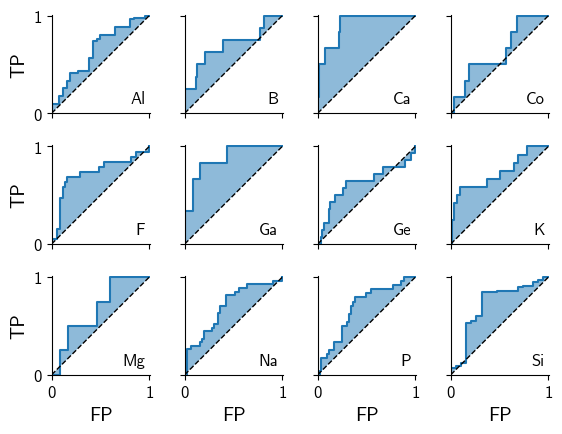

In [10]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["fpr"].item()
    _y = _df["tpr"].item()
    
    ax.plot(_x, _y)
    ax.plot(_x, _x, linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        _x,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
    ax.annotate(label, (0.95, 0.1), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("FP")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("TP")
    
    
fig.tight_layout()

plt.show()

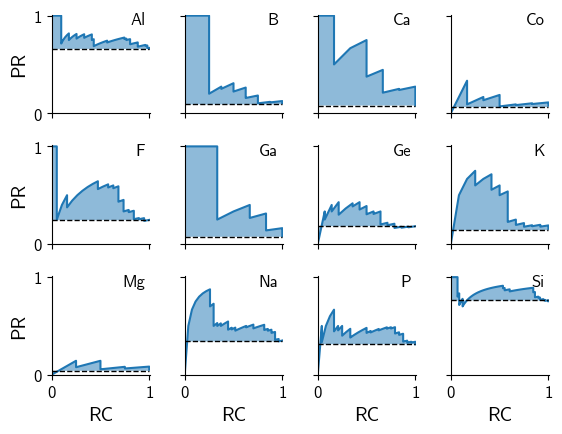

In [11]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["rc"].item()
    _y = _df["pr"].item()
    
    baseline = _df["n_pos"] / (_df["n_pos"] + _df["n_neg"])
    
    ax.plot(_x, _y)
    ax.plot([0, 1], [baseline, baseline], linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        baseline,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
#     ax.set_xlabel("FP")
#     ax.set_ylabel("TP")
    ax.annotate(label, (0.95, 0.9), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("RC")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("PR")
    
    
fig.tight_layout()

plt.show()

In [12]:
results_df[["label", "accuracy", "precision", "recall", "F1-score", "roc_auc"]]

,label,accuracy,precision,recall,F1-score,roc_auc
0,Al,0.701299,0.725806,0.882353,0.796460,0.646305
1,B,0.922078,1.000000,0.250000,0.400000,0.697464
2,Ca,0.934211,0.666667,0.333333,0.444444,0.909524
3,Co,0.909091,0.000000,0.000000,0.000000,0.631455
4,F,0.805195,0.611111,0.578947,0.594595,0.729583
5,Ga,0.935065,0.666667,0.333333,0.444444,0.873239
6,Ge,0.805195,0.400000,0.142857,0.210526,0.622449
7,K,0.857143,0.600000,0.250000,0.352941,0.728205
8,Mg,0.948052,0.000000,0.000000,0.000000,0.671233
9,Na,0.649351,0.500000,0.296296,0.372093,0.698519
